**RandomForest**

In [1]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV

In [2]:
dataset = pd.read_csv('dataset_anomaly_threshold_1.2.csv')

In [3]:
dataset.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
com_columns = dataset.columns.tolist()

In [5]:
com_columns

['Wmi_SerialNumber',
 'socket',
 'channel',
 'bank',
 'Generation_x',
 'ClusterType_x',
 'HwSkuId_x',
 'BIOSVersion',
 'CPUID',
 'MemoryManufacturer',
 'MemoryPartNumber',
 'AgeOfDimm',
 'UEfit_sum',
 'MA_Uefit',
 'logMA_Uefit',
 'fm_nibble7_sum',
 'fm_nibble6_sum',
 'fm_nibble5_sum',
 'fm_nibble4_sum',
 'fm_nibble3_sum',
 'fm_nibble2_sum',
 'fm_nibble1_sum',
 'fm_nibble0_sum',
 'cnt_rk7_sum',
 'cnt_rk6_sum',
 'cnt_rk5_sum',
 'cnt_rk4_sum',
 'cnt_rk3_sum',
 'cnt_rk2_sum',
 'cnt_rk1_sum',
 'cnt_rk0_sum',
 'diffUECount_sum',
 'DimmTemp_avg',
 'TotalDIMMCount_sum',
 'repeatue_sum',
 'z_ma_uefit',
 'anomaly_label',
 'anomaly_id']

In [6]:
subset_cols = ['AgeOfDimm', 'MemoryManufacturer','diffUECount_sum', 'TotalDIMMCount_sum', 'fm_nibble7_sum', 'fm_nibble6_sum', 'fm_nibble5_sum', 'fm_nibble4_sum', 'fm_nibble3_sum', 'fm_nibble2_sum', 'fm_nibble1_sum','fm_nibble0_sum', 'cnt_rk7_sum', 'cnt_rk6_sum', 'cnt_rk5_sum', 'cnt_rk4_sum', 'cnt_rk3_sum', 'cnt_rk2_sum', 'cnt_rk1_sum', 'cnt_rk0_sum', 'DimmTemp_avg', 'repeatue_sum', 'anomaly_label']
dataset_sub = dataset[subset_cols]

In [7]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    
dataset_encoded = pd.DataFrame(encoder.fit_transform(dataset_sub[['MemoryManufacturer']]))
dataset_encoded.columns = encoder.get_feature_names(['MemoryManufacturer'])
dataset_sub.drop(['MemoryManufacturer'], axis=1, inplace=True)
    
dataset_sub_enc = pd.concat([dataset_encoded, dataset_sub], axis=1)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
X = dataset_sub_enc.drop(axis=1, labels=['anomaly_label'])
y = dataset_sub_enc['anomaly_label']

#X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(y.value_counts())

0    3454
1     348
Name: anomaly_label, dtype: int64


In [9]:
algorithm_stats = pd.DataFrame()

In [10]:
def print_report(y_true, y_pred):
    print('Accuracy: %.4f\n' % (accuracy_score(y_true, y_pred)))
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=['Non-Anomaly', 'Anomaly']))
    #print(confusion_matrix(y_true, y_pred))
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred))
    cm['Total'] = np.sum(cm, axis=1)
    cm = cm.append(np.sum(cm, axis=0), ignore_index=True)
    cm.columns = ['Predicted Non-Anomaly', 'Predicted Anomaly', 'Total']
    cm = cm.set_index([['Actual Non-Anomaly', 'Actual Anomaly', 'Total']])
    print(cm)

def create_stats(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    stats = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return pd.Series([acc, stats[0], stats[1], stats[2]], index=['Accuracy', 'Precision', 'Recall', 'F1'])

In [11]:
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)], 
    'max_depth': [int(x) for x in np.linspace(start = 1, stop = 100, num = 20)], 
    'min_weight_fraction_leaf': np.arange(0.1, 0.5, 0.1),
    'min_samples_split': [2, 4, 8, 16, 32, 64, 128],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'criterion': ['gini', 'entropy'],
    'oob_score': [True, False]
}

clf_forest = RandomizedSearchCV(
    estimator=RandomForestClassifier(verbose=2), 
    param_distributions=param_grid, 
    n_iter=100,
    cv=5,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

clf_forest.fit(X_train, y_train)

print(f'Best  score: {clf_forest.best_score_}')
print(f'Best params: {clf_forest.best_params_}\n')

algorithm_stats['RandomForest'] = create_stats(y_test, clf_forest.predict(X_test))
print_report(y_test, clf_forest.predict(X_test))

building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


In [12]:
rf_clf = RandomForestClassifier()
rf_clf.set_params(**clf_forest.best_params_)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=63, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.1, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
sizes = [10, 100, 400, 800, 1200, 1600, 2000, 2394]
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=rf_clf,
    X = X_train,
    y = y_train,
    train_sizes = sizes,
    cv = 10,
    scoring = 'f1'
)

train_score_mean = train_scores.mean(axis=1)
validation_score_mean = validation_scores.mean(axis=1)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


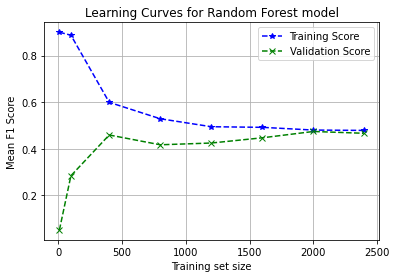

In [14]:
idx_train_size = [i for i, element in enumerate(train_score_mean) if element == 0]

if idx_train_size:
    train_sizes = np.delete(train_sizes, idx_train_size)
    train_score_mean = [i for i in train_score_mean if i != 0]
    validation_score_mean = [i for i in validation_score_mean if i != 0]

plt.plot(train_sizes, train_score_mean, marker='*', linestyle='--',color='blue',label='Training Score')
plt.plot(train_sizes, validation_score_mean, marker='x', linestyle='--', color='green',label='Validation Score')
plt.ylabel('Mean F1 Score')
plt.xlabel('Training set size')
plt.title('Learning Curves for Random Forest model')
plt.grid()
plt.legend()

Best Threshold=0.630516, F-Score=0.525


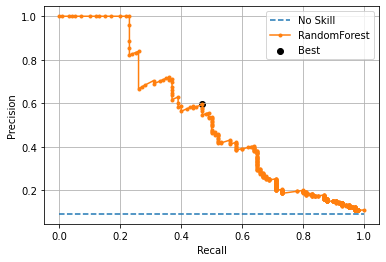

In [15]:
from numpy import argmax

# predict probabilities
ypred = rf_clf.predict_proba(X_test)
# retrieve the probabilities for the positive class (anomaly)
pos_probs = ypred[:, 1]
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1])/len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, pos_probs)
# convert to f score
fscore = (2*precision*recall)/(precision+recall)
# locate index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the model precision recall curve
plt.plot(recall, precision, marker='.', label='RandomForest')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.savefig('RandomForest_PR_Threshold')
plt.show()

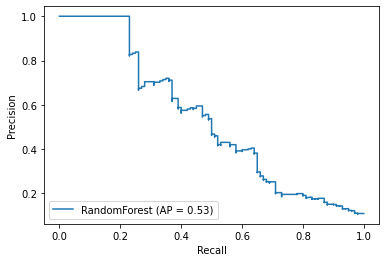

In [16]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(rf_clf, X_test, y_test, name='RandomForest')

In [17]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return(pos_probs >= threshold).astype('int')

In [18]:
from numpy import arange
from numpy import argmax
from sklearn.metrics import f1_score
# define thresholds
self_thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(pos_probs, t)) for t in self_thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (self_thresholds[ix], scores[ix]))

Threshold=0.627, F-Score=0.52514


In [19]:
t = self_thresholds[ix]
algorithm_stats['RandomForest_NewThreshold'] = create_stats(y_test, to_labels(pos_probs, t))
print_report(y_test, to_labels(pos_probs, t))

Accuracy: 0.9255

Classification Report:
              precision    recall  f1-score   support

 Non-Anomaly       0.95      0.97      0.96      1041
     Anomaly       0.59      0.47      0.53       100

    accuracy                           0.93      1141
   macro avg       0.77      0.72      0.74      1141
weighted avg       0.92      0.93      0.92      1141

                    Predicted Non-Anomaly  Predicted Anomaly  Total
Actual Non-Anomaly                   1009                 32   1041
Actual Anomaly                         53                 47    100
Total                                1062                 79   1141


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


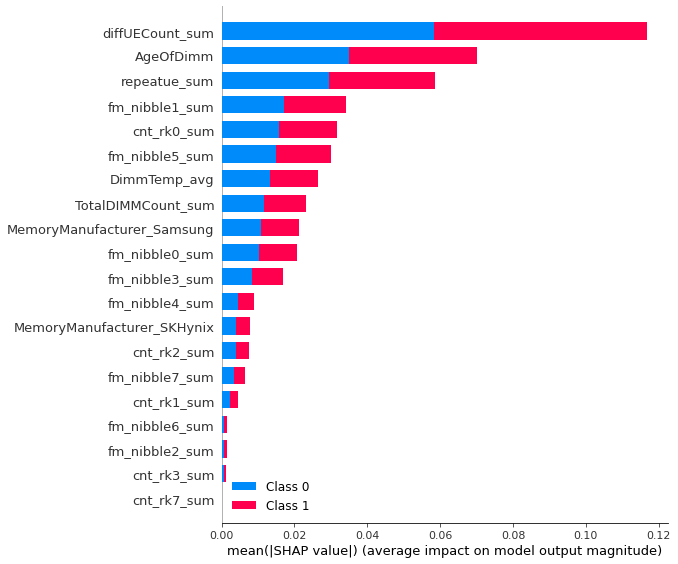

In [20]:
import shap

explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)